#  2017-12-01  SVMs

In this lab, we will apply support vector classification methods to the Endometrium vs. Uterus cancer data. For documentation see: http://scikit-learn.org/0.17/modules/svm.html#svm.

### Load data

We will start as usual with library imports and loading data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
# import data from file
df_data = pd.read_csv('./data/small_Endometrium_Uterus.csv')

# create matrix of numeric values
X = df_data.drop(['ID_REF', 'Tissue'], axis=1).as_matrix()

# extract class column
y = (df_data['Tissue'] == 'Uterus').as_matrix().astype(int)

In [3]:
# Print data dimensions
print('No. samples: %d\nNo. features: %d' % X.shape)

No. samples: 183
No. features: 3000


### Visualise data in two dimensions

We will start by visualising the data projected onto the first two principal components:

In [4]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

# normalise data
X_scaled = preprocessing.normalize(X)

NUM_COMPONENTS = 2

pca_model = PCA(n_components=NUM_COMPONENTS)
Z = pca_model.fit_transform(X_scaled)

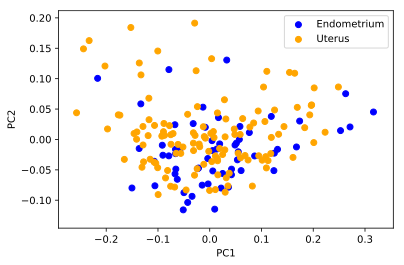

In [5]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

plt.scatter(Z[y==0, 0], Z[y==0, 1], label='Endometrium', color='blue')
plt.scatter(Z[y==1, 0], Z[y==1, 1], label='Uterus', color='orange')
plt.xlabel('PC1') ; plt.ylabel('PC2')
plt.legend()

## 1. Linear SVM

In [6]:
from sklearn import svm

### 1.1 SVM decision function

SVMs do not naturally compute probabilities. It is possible to convert the output of the decision function into a probability, but that is a computationally intensive procedure, called Platt's scaling. You can read about it in the corresponding paper: https://www.microsoft.com/en-us/research/publication/probabilities-for-sv-machines/.

The natural way for SVMs to return scores (and not predicted classes) is to use the output of their decision function directly.

**Question:** Modify the `cross_validate` function to return as predictions the values of the `svm.decision_function`.

In [42]:
def cross_validate(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns, for each data point x, 
    the value of the decision function f computed when x was part of the test set. 

    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - decision_function(X) to apply the trained classifier to the data X 
        and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.

    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape) # Hold all predictions, in correct order.
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]

        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Compute decision function on test data
        yte = classifier.decision_function(Xte)
        
        # Update pred 
        pred[te] = yte

    return pred

### 1.2 Linear SVM with default C value

Let us cross-validate an SVM with linear kernel (linear soft-margin SVM) with default C parameter.

**N.B.** the k-fold `split()` function creates a generator that will have to be initialised each time.

In [44]:
# Set up a stratified 10-fold cross-validation
from sklearn import model_selection
skf = model_selection.KFold(10, shuffle=True)
cv_folds = skf.split(X, y)  # generator for train, test folds
clf = svm.SVC(kernel='linear')
ypred_linear = cross_validate(X, y, clf, cv_folds)

**Question:** Plot the corresponding ROC curve.

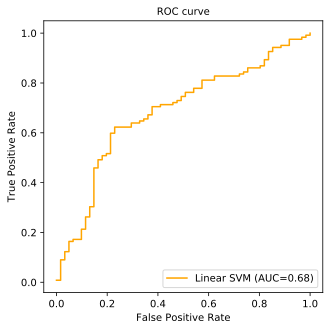

In [45]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, ypred_linear)
auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr,
         color='orange',
         label='Linear SVM (AUC=%.2f)' % auc)

ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.set_title('ROC curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)

**Question:** Why is the result so poor? *(Hint: look at the PCA plot from earlier)*

**Answer:** Not linearly separable

### 1.3 Number of support vectors

The `n_support_` atritbute of an svm classifier gives us the number of support vectors for each class.

**Question:** How many support vectors does our classifier have? How many is this compared to the number of training samples?

In [48]:
clf = svm.SVC(kernel='linear')
clf.fit(X,y)
print(len(clf.support_), "support vectors for", len(X), "training samples")

119 support vectors for 183 training samples


### 1.4 Kernel matrix

The kernel matrix is the matrix of size $n \times n$ that has for entry $K_{ij}$ the value $k(x^i, x^j)$, where $k$ is the kernel function used.

In the case of the linear kernel, the kernel function is simply the inner product.

**Question**: Plot the matrix $\mathbf{K}$ for the linear kernel.

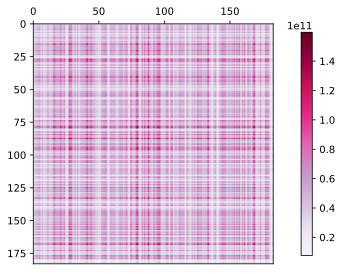

In [116]:
from sklearn.metrics import pairwise
kmatrix = pairwise.pairwise_kernels(X)
# kamtrix = [[np.dot(X[i,:], X[j,:]) for j in range(len(X))] for i in range(len(X))]

# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(kmatrix, cmap=plt.cm.PuRd) 

# set axes boundaries
ax.set_xlim([0, X.shape[0]]) ; ax.set_ylim([0, X.shape[0]])

# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()

# plot colorbar to the right
plt.colorbar(plot, pad=0.1, fraction=0.04)

**Question:** What do you observe about the values taken by the kernel?

**Answer**:

Now let's scale the data before computing the kernel:

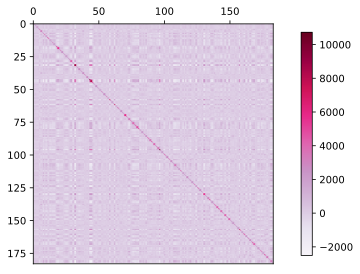

In [117]:
X_scaled = preprocessing.scale(X)
kmatrix = pairwise_kernels(X_scaled)

# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(kmatrix, cmap=plt.cm.PuRd) 

# set axes boundaries
ax.set_xlim([0, X.shape[0]]) ; ax.set_ylim([0, X.shape[0]])

# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()

# plot colorbar to the right
plt.colorbar(plot,  pad=0.1, fraction=0.04)

**Question:** What is the effect of scaling?

**Answer:** Better

Now let's see how scaling affects the performance of the linear SVM:

In [118]:
def cross_validate_with_scaling(design_matrix, labels, classifier, cv_folds):
    """ Perform a cross-validation and returns, for each data point x, 
    the value of the decision function f computed when x was part of the test set. 
    
    Scale the training data, and apply same scaling to the test data.
   
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  sklearn classifier object
        Classifier instance; must have the following methods:
        - fit(X, y) to train the classifier on the data X, y
        - decision_function(X) to apply the trained classifier to the data X 
        and return probability estimates 
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        
        # Create scaler object
        scaler = preprocessing.StandardScaler()
        
        # Fit the scaler and transform training data
        Xtr_scaled = scaler.fit_transform(Xtr)
        
        # Transform test data
        Xte_scaled = scaler.transform(Xte)
        
        # Fit classifier
        classifier.fit(Xtr_scaled, ytr)

        # Compute decision function on test data (as before)
        yte = classifier.decision_function(Xte_scaled)
        
        # Update pred
        pred[te] = yte
        
    return pred

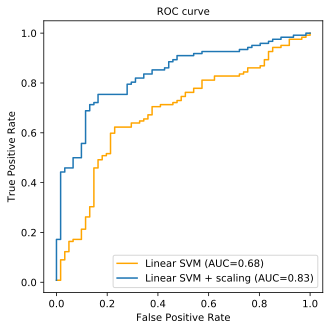

In [119]:
cv_folds = skf.split(X, y)  # generator for train, test folds
clf = svm.SVC(kernel='linear') 
ypred_linear_scaled = cross_validate_with_scaling(X, y, clf, cv_folds)

fpr2, tpr2, thresholds2 = metrics.roc_curve(y, ypred_linear_scaled)
auc2 = metrics.auc(fpr2, tpr2)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr,
         color='orange',
         label='Linear SVM (AUC=%.2f)' % auc)

plt.plot(fpr2, tpr2,
         label='Linear SVM + scaling (AUC=%.2f)' % auc2)

ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.set_title('ROC curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)

**Question:** Now optimise for the C-parameter within each loop of the cross-validation. Plot the new ROC curve (you should set the GridSearchCV scoring parameter so that it will create the roc curves).

In [120]:
from sklearn.model_selection import GridSearchCV
parameters_dict = {'C': np.logspace(-4, 2, 7)}

# Perform a Grid Search
clf_C = GridSearchCV(svm.SVC(kernel='linear'), parameters_dict)
clf_C.fit(X, y)

y_cv_C = clf_C.best_estimator_.decision_function(X)
fpr_C, tpr_C, thresholds = metrics.roc_curve(y, y_cv_C)
auc_C = metrics.auc(fpr_C, tpr_C)

{'C': 0.0001}


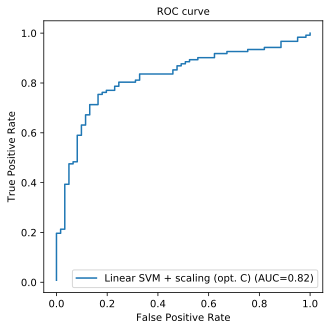

In [121]:
cv_folds = skf.split(X, y)  # generator for train, test folds
clf_opt = clf_C.best_estimator_
ypred_linear_scaled = cross_validate_with_scaling(X, y, clf_opt, cv_folds)

fpr2, tpr2, thresholds2 = metrics.roc_curve(y, ypred_linear_scaled)
auc2 = metrics.auc(fpr2, tpr2)

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(fpr2, tpr2,
         label='Linear SVM + scaling (opt. C) (AUC=%.2f)' % auc2)

ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.set_title('ROC curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)
print(clf_C.best_params_)

## 2. Polynomial kernels

We will use SVMs with kernels of the form $k(x, x') = (\langle x, x' \rangle + r)^d$.

**Question**: Plot kernel matrices for $r=0, d=2$.

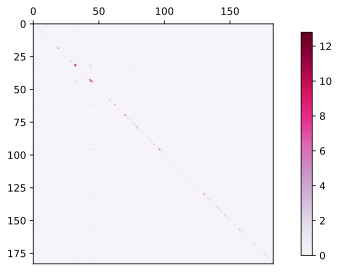

In [142]:
# normalise data
X_scaled = preprocessing.scale(X)

# Construct kernel matrix with r = 0 and d = 2
r = 0
d = 2

# Form the kernel matrix
kmatrix = pairwise.polynomial_kernel(X_scaled, degree=d, coef0=r)

# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(kmatrix, cmap=plt.cm.PuRd)

# set axes boundaries
ax.set_xlim([0, X.shape[0]]) ; ax.set_ylim([0, X.shape[0]])

# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()

# plot colorbar to the right
plt.colorbar(plot, pad=0.1, fraction=0.04)

**Question:** What do you observe? What is going to happen if you increase $d$? How do you think this will affect the SVM? Cross-validate the SVM and plot the ROC curve.

**Answer:**

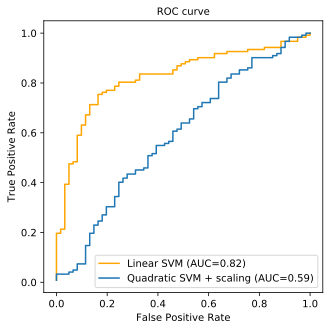

In [143]:
cv_folds = skf.split(X, y)  # generator for train, test folds
clf = svm.SVC(kernel='poly', degree=d, coef0=r)
ypred_quadratic = cross_validate_with_scaling(X, y, clf, cv_folds)
fpr3, tpr3, thresholds3 = metrics.roc_curve(y, ypred_quadratic)
auc3 = metrics.auc(fpr3, tpr3)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr2, tpr2,
         color='orange',
         label='Linear SVM (AUC=%.2f)' % auc2)

plt.plot(fpr3, tpr3,
         label='Quadratic SVM + scaling (AUC=%.2f)' % auc3)

ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.set_title('ROC curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)

**Question**: What value for $r$ can change this behavior? Plot the corresponding kernel matrix.

**Answer:**

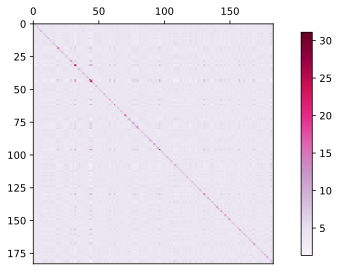

In [154]:
X_scaled = preprocessing.scale(X)

# Set the r parameter to something suitable
r =  2
d = 2

# Form kernel matrix
kmatrix = pairwise.polynomial_kernel(X_scaled, degree=d, coef0=r)

# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(kmatrix, cmap=plt.cm.PuRd) 

# set axes boundaries
ax.set_xlim([0, X.shape[0]]) ; ax.set_ylim([0, X.shape[0]])

# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()

# plot colorbar to the right
plt.colorbar(plot, pad=0.1, fraction=0.04)

**Question**: Now evaluate an SVM with polynomial kernel of degree d=2 and value for r as above.

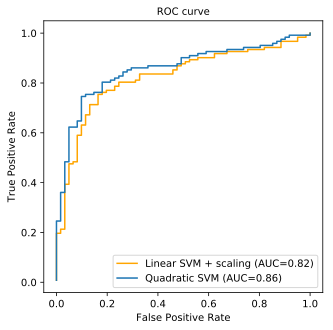

In [155]:
cv_folds = skf.split(X_scaled, y)  # generator for train, test folds
clf = svm.SVC(kernel='poly', degree=d, coef0=r)
ypred_quadratic = cross_validate_with_scaling(X, y, clf, cv_folds)
fpr4, tpr4, thresholds4 = metrics.roc_curve(y, ypred_quadratic)
auc4 = metrics.auc(fpr4, tpr4)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr2, tpr2,
         color='orange',
         label='Linear SVM + scaling (AUC=%.2f)' % auc2)

plt.plot(fpr4, tpr4,
         label='Quadratic SVM (AUC=%.2f)' % auc4)

ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.set_title('ROC curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)

## 3. Gaussian RBF kernels

We will use SVMs with kernels of the form $k(x, x') = \exp \left(-\gamma ||x - x'||^2 \right)$.

The following code efficiently computes the pairwise squared distances between all items in X, that is to say the matrix $P$ such that $P_{ij} = ||x^i - x^j||^2$.

In [ ]:
from scipy.spatial.distance import pdist, squareform
pairwise_sq_dists = squareform(pdist(X, 'sqeuclidean'))

**Question**: Plot kernel matrices for varying values of $\gamma$. What do you observe? What is going to be the impact on the SVM? What happens with very small values of $\gamma$?

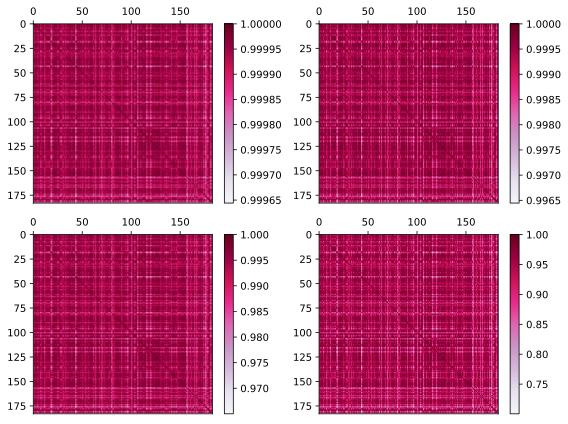

In [172]:
from sklearn.metrics.pairwise import rbf_kernel
X_scaled = preprocessing.normalize(X)

fig = plt.figure(figsize=(8, 6))

# Create list of gamma values to try
gamma_values = [0.001,0.01,0.1,1] #TODO

for i, gamma in enumerate(gamma_values):
    ax = fig.add_subplot(2, 2, i + 1)
    pairwise_sq_dists = rbf_kernel(X_scaled, gamma=gamma)

    # heatmap + color map
    plot = ax.imshow(pairwise_sq_dists, cmap=plt.cm.PuRd) 

    # set axes boundaries
    ax.set_xlim([0, X.shape[0]]) ; ax.set_ylim([0, X.shape[0]])

    # flip the y-axis
    ax.invert_yaxis() ; ax.xaxis.tick_top()

    # plot colorbar to the right
    plt.colorbar(plot)

plt.tight_layout()

**Question:** Compare the performance of an rbf SVM (for a given choice of gamma) with the linear SVM:

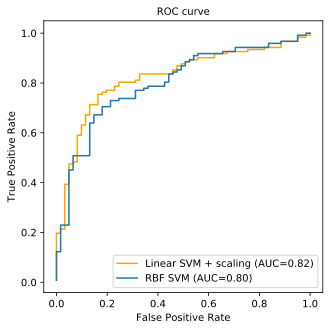

In [171]:
cv_folds = skf.split(X, y)  # generator for train, test folds

# Create rbf kernel
clf = svm.SVC(kernel='rbf')
ypred_rbf = cross_validate_with_scaling(X, y, clf, cv_folds)

fpr5, tpr5, thresholds5 = metrics.roc_curve(y, ypred_rbf)
auc5 = metrics.auc(fpr5, tpr5)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr2, tpr2,
         color='orange',
         label='Linear SVM + scaling (AUC=%.2f)' % auc2)

plt.plot(fpr5, tpr5,
         label='RBF SVM (AUC=%.2f)' % auc5)

ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.set_title('ROC curve', fontsize=10)
plt.legend(loc='lower right', fontsize=10)

## 4. Bonus: Coding an SVM

We have coded a working SVM with a simplified version of the specialised SMO algorithm (see below). It is based on a tutorial from Stanford course CS229 (http://cs229.stanford.edu/materials/smo.pdf). Since it is a messy algorithm, we will walk through it and ask you to code small parts only. For future reference, recall the form of an SVM in the dual form:

\begin{equation}
\begin{array}{rl}
\max_{\boldsymbol\alpha} & W(\boldsymbol\alpha) = \sum_{i = 1}^{N}\alpha_i + \frac{1}{2}\sum_{i}^N\sum_{j}^N \alpha_i\alpha_jy_iy_j\mathbf{x}_i^T\mathbf{x}_j \\
\text{subject to} & \sum_{i=1}^N \alpha_iy_i = 0 \\
& 0 \leq \alpha_i \leq C, \forall i
\end{array}
\end{equation}

### 4.1 SVM Decision function

In the dual form, the decision function of an SVM is given as,

$$
f(\mathbf{\mathbf{x}}) = \sum_{i=1}^N \alpha_iy_i\kappa(\mathbf{x}_i, \mathbf{x}) + b,
$$

and a prediction is then made as $\text{sgn}\big(f(\mathbf{x})\big)$ where $\text{sgn} : x \to \{1, -1\}$ is the sign function. One can see how an observation $\mathbf{x}$ is classified according to its similarity with the training vectors. Each training vector, $\mathbf{x}_i$, casts its vote, $y_i$, be it $-1$ or $1$, with the influence regulated by a similarity measure provided by the kernel function, and the weight provided by the dual variable. Only the support vectors have a (non-zero) weighted vote. It is easy to see why this is such a powerful framework--we can choose between many similarity measures (kernels), though the mathematics restricts us to choosing Mercer kernels.

**Question:** Write the `decision_function()` (not the prediction) for an SVM. Assume `Ki` is a precomputed vector giving all kernel values $\kappa(\mathbf{x}_i, \mathbf{x})$:

In [173]:
def decision_function(Ki, y, a, b):
    return lambda x: np.sum(np.array([a[i]*y[i]*Ki(x[i], x) for i in range(len(x))])) + b

### 4.2 Sequential Minimal Optimisation

Our model may be solved with any QP solver, formerly the standard approach. However, in 1998, American computer scientist, John Platt (1963-), invented sequential minimal optimisation (SMO), an algorithm for analytically optimising the dual variables two at a time. The superiority and simplicity of this algorithm helped bring support vector machines into the forefront of machine learning research. The algorithm works by iteratively optimising pairs of variables that violate the optimality conditions. These are,

\begin{align}
\begin{array}{rcl}
\alpha_i = 0 & \implies & y_if(\mathbf{x}_i) \geq 1 \notag\\
0 < \alpha_i < C  & \implies & y_if(\mathbf{x}_i) = 1 \notag \\
\alpha_i = C & \implies & y_if(\mathbf{x}_i) \leq 1 \notag
\end{array}
\end{align}

#### Updating the weights

Optimisation is done *in pairs* (this is what *minimal* refers to in SMO) in order to maintain the equality constraint of the problem, $\sum_{i=1}^N \alpha_iy_i = 0$ (see above). Thus, for pair $\alpha_i$ and $\alpha_j$, we make updates such that $y_i\Delta\alpha_i + y_j\Delta\alpha_j = 0$. Rearranging gives $\Delta\alpha_j = -\Delta\alpha_iy^{(i)}/y^{(j)} = -\Delta\alpha_iy^{(i)}y^{(j)}$, as since $y_i \in \{-1, 1\}$, division is the same as multiplication, and the cost function becomes,

\begin{align}
W(\boldsymbol\alpha) &= \sum_{k=1}^N\alpha_k + \Delta\alpha_i -\Delta\alpha_iy_iy_j - \frac{1}{2}\sum_{k=1}^Ny_k\alpha_k\big(f(\mathbf{x}_k) - b\big) \notag \\ 
&- \Delta\alpha_i\big(f(\mathbf{x}_i) - f(\mathbf{x}_j)\big) - \Delta\alpha_iy_i\big(f(\mathbf{x}_i) - f(\mathbf{x}_j)\big) - \frac{1}{2}\Delta\alpha_i^2\big(\kappa(\mathbf{x}_i, \mathbf{x}_i) - 2\kappa(\mathbf{x}_i, \mathbf{x}_j) + \kappa(\mathbf{x}_j, \mathbf{x}_j)\big). \notag 
\end{align}

Differentiating and solving gives,

$$\Delta\alpha_j^* = \frac{y_j(E_i - E_j)}{2\kappa(\mathbf{x}_i, \mathbf{x}_j) - \kappa(\mathbf{x}_i, \mathbf{x}_i) - \kappa(\mathbf{x}_j, \mathbf{x}_j)},$$

where $E_i = f(\mathbf{x}_i) - y_i$ and $E_j = f(\mathbf{x}_j) - y_j$ are the errors.

**Question:** Write the function to calculate `delta_a()`. Use `i` and `j` to index the kernel matrix. Note that for simplicity, we assume the errors have been calculated already:

In [ ]:
def delta_a(K, y, i, j, Ei, Ej):
    delta_a = # TODO
    return delta_a

This gives us our update step. The value of $\Delta\alpha_j^*$ can then be determined from the initial equality. Note that both variables remain constrained, hence their values must be clipped if they are less than $0$ or greater than $C$.

#### Updating the bias

The bias term is then updated to account for the changes. For example, to ensure the classifier now emits $y_i$ for $f(\mathbf{x}_i)$, we rearrange,

$$y_i = \sum_{k=1}^N \alpha_iy_i\kappa(\mathbf{x}_k, \mathbf{x}_i) + b + \Delta b + \Delta\alpha y_i\kappa(\mathbf{x}_i, \mathbf{x}_i) + \Delta\alpha y_j\kappa(\mathbf{x}_i, \mathbf{x}_j),$$

for $\Delta b^*$. The same is done for $f(\mathbf{x}_j)$, and the expressions are combined according to the convergence conditions. Thus, the optimisation steps are done analytically, rather than with linear algebra. The rest of the algorithm is mostly concerned with heuristics for choosing the best $\alpha_i$, $\alpha_j$ pair.

### 4.3 Putting it all together

Your functions will be called by the class `SupportVectorMachine` defined below. *(you do not need to change anything, just compile it and move on...)*

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

class SupportVectorMachine:

    def __init__(self, kernel='linear', gamma=0.01, d=2, r=0):

        """ Initialisation function for support vector machine

        Parameters:
        -----------
        kernel: {linear, rbf, polynomial} string
                Indicates the kernel function to use
        gamma:  float
                Variance of rbf kernel
        d:      float
                Degree for polynomial kernel
        r:      float
                Consant for polynomial kernel
        """
        if kernel == 'linear':
            self.kernel = lambda x, y : x.dot(y.T)
        elif kernel == 'rbf':
            self.kernel = lambda x, y : rbf_kernel(x, y, gamma=0.01)
        elif kernel == 'polynomial':
            self.kernel = lambda x, y : (x.dot(y.T) + r) ** d

    def predict(self, x):

        """ Prediction function for support vector machine

        Parameters:
        -----------
        x:      (1, n_features) np.array
                Test sample

        Return:
        -------
        prediction: {-1, 1}
            Sign of output of linear score function
        """
        # calculate kernel values for input x
        kx = self.kernel(self.Xtr, x.reshape(1, -1))
        return np.sign(self.a.dot(np.diag(ytr)).dot(kx) + self.b)

    def decision_function(self, Ki):

        """ Decision function for support vector machine

        Parameters:
        -----------
        x:      (1, n_features) np.array
                Test sample

        Return:
        -------
        prediction: float
            Output of linear score function
        """
        return decision_function(Ki, self.ytr, self.a, self.b)

    def fit(self, Xtr, ytr, C=0.01, tol=1e-5, max_iters=100):

        """ Training algorithm for support vector machine.
        
        SMO sequential minimal optimisation algorithm for training. 
        This is the simplified version (without heuristics) detailed in
        cs229.stanford.edu/materials/smo.pdf

        Parameters:
        -----------
        Xtr:       (n_samples, n_features) np.array
                   First data matrix.
        ytr:       (n_samples, 1) np.array
                   Second data matrix.
        C:         float
                   margin size
        tol:       float
                   precision on optimality (stopping condition)
        max_iters: int
                   maximum number of optimisation passes"""

        self.Xtr = Xtr
        self.ytr = ytr

        N = self.Xtr.shape[0]
        K = self.kernel(self.Xtr, self.Xtr)  # kernel matrix

        self.a = np.zeros(N)  # support vector weights
        self.b = 0  # bias term

        iters = 0

        while iters < max_iters:
            num_changed = 0
            # iterate over samples
            for i in range(N):
                # Calculate error
                Ei = self.decision_function(K[i]) - self.ytr[i]
                # Check optimality constraints
                
                if (self.ytr[i] * Ei < -tol and self.a[i] < C) or \
                   (self.ytr[i] * Ei > +tol and self.a[i] > 0):

                    # Pick random aj
                    j = np.random.choice(filter(lambda x : x != i, range(N)))
                    Ej = self.decision_function(K[j]) - self.ytr[j]

                    # Record ai, aj
                    ai_old = self.a[i]
                    aj_old = self.a[j]

                    # Set bounds
                    L = 0 ; H = 0
                    if self.ytr[i] != self.ytr[j]:
                        L = max(0, self.a[j] - self.a[i])
                        H = min(C, C + self.a[j] - self.a[i])
                    else:
                        L = max(0, self.a[i] + self.a[j] - C)
                        H = min(C, self.a[i] + self.a[j])

                    if L == H:
                        continue
    
                    # Update aj
                    self.a[j] -= delta_a(K, self.ytr, i, j, Ei, Ej)

                    # Clip value
                    self.a[j] = max(min(self.a[j], H), L)

                    # Check for change
                    if abs(self.a[j] - aj_old) < tol:
                        continue

                    # Update ai
                    self.a[i] += self.ytr[i] * self.ytr[j] * (aj_old - self.a[j])

                    # Set bias term
                    b1 = self.b - Ei - \
                         self.ytr[i] * (self.a[i] - ai_old) * K[i, i] - \
                         self.ytr[j] * (self.a[j] - aj_old) * K[i, j]

                    b2 = self.b - Ej - \
                         self.ytr[i] * (self.a[i] - ai_old) * K[i, j] - \
                         self.ytr[j] * (self.a[j] - aj_old) * K[j, j]

                    if 0 < self.a[i] and self.a[i] < C:
                        self.b = b1
                    elif 0 < self.a[j] and self.a[j] < C:
                        self.b = b2
                    else:
                        self.b = float(b1 + b2) / 2

                    num_changed += 1

            iters = iters + 1 if num_changed == 0 else 0

### 4.4 Linearly separable data

We will now test our implementation on some toy data. We being by creating a random dataset sampled from two distinct Gaussians:

In [ ]:
from numpy.random import multivariate_normal

num_samples = 100

X = np.concatenate((multivariate_normal(mean=np.array([1, 1]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples),
                    multivariate_normal(mean=np.array([-1, -1]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples)))

y = np.array(num_samples * [1] + num_samples * [-1])

# visualise mesh as contour plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('x1') ; ax.set_ylabel('x2')

# plot training data
plt.scatter(X[:num_samples, 0], X[:num_samples, 1], color='orange')
plt.scatter(X[num_samples:, 0], X[num_samples:, 1], color='blue')

Now let's train our custom SVM with a linear kernel:

In [ ]:
# create train-test split
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X, y)

# train linear SVM
clf = SupportVectorMachine(kernel='linear')
clf.fit(Xtr, ytr, C=0.5, max_iters=100)

# calculate accuracy on test set
linear_pred = np.array([clf.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(linear_pred==yte)) / yte.shape[0]
print('Accuracy (linear): %.00f%%' % (100 * acc))

Visualise decision boundary:

In [ ]:
# create mesh coordinates
lim = 5
xx, yy = np.meshgrid(np.arange(-lim, +lim, 0.1),
                     np.arange(-lim, +lim, 0.1))
zz = np.zeros(xx.shape)

# create mesh of predictions
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz[i, j] = clf.predict(np.array([xx[i, j], yy[i, j]]))

# visualise mesh as contour plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('x1') ; ax.set_ylabel('x2')
ax.set_xlim([-lim, +lim-0.1]) ; ax.set_ylim([-lim, +lim-0.1])
ax.contourf(xx, yy, zz, alpha=0.5, colors=('blue', 'orange'))

# plot training data
plt.scatter(X[:num_samples, 0], X[:num_samples, 1], color='orange')
plt.scatter(X[num_samples:, 0], X[num_samples:, 1], color='blue')

No problem! Now for something a little more challenging...

### 4.5 Non-linear decision boundaries

Now we will try data that is not linearly separable: a circle inside a square! We will see that our linear kernel is insufficient:

In [ ]:
from numpy.random import multivariate_normal

num_samples = 200

X = np.random.uniform(low=-1, high=1, size=(num_samples, 2))
y = np.array([1 if np.sqrt(np.dot(x, x.T)) < 1 / np.sqrt(2) else -1 for x in X])

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('x1') ; ax.set_ylabel('x2')

class_pos = filter(lambda i : y[i] == +1,  np.arange(X.shape[0]))
class_neg = filter(lambda i : y[i] == -1,  np.arange(X.shape[0]))

# plot training data
plt.scatter(X[class_pos, 0], X[class_pos, 1], color='orange')
plt.scatter(X[class_neg, 0], X[class_neg, 1], color='blue')

Uh oh! Polynomial kernels to the rescue!

In [ ]:
# create train-test split
Xtr, Xte, ytr, yte = train_test_split(X, y)

# train linear SVM
clf_linear = SupportVectorMachine(kernel='linear')
clf_linear.fit(Xtr, ytr, C=0.1, max_iters=100)

# calculate accuracy on test set
linear_pred = np.array([clf_linear.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(linear_pred==yte)) / yte.shape[0]
print('Accuracy (linear): %.00f%%' % (100 * acc))

# train quadratic kernel SVM
clf_poly = #TODO

# calculate accuracy on test set
quad_pred = np.array([clf_poly.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(quad_pred==yte)) / yte.shape[0]
print('Accuracy (quadratic): %.00f%%' % (100 * acc))

We plot the decision boundaries for the quadratic kernel:

In [ ]:
# create mesh coordinates
lim = 1
xx, yy = np.meshgrid(np.arange(-lim, +lim, 0.1), np.arange(-lim, +lim, 0.1))
zz_poly = np.zeros(xx.shape)

# create mesh of predictions
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz_poly[i, j] = clf_poly.predict(np.array([xx[i, j], yy[i, j]]))

# visualise mesh as contour plot
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('x1') ; ax.set_ylabel('x2')
ax.set_xlim([-lim, +lim-0.1]) ; ax.set_ylim([-lim, +lim-0.1])
ax.contourf(xx, yy, zz_poly, alpha=0.5, colors=('blue', 'orange'))

# plot training data
ax.scatter(X[class_pos, 0], X[class_pos, 1], color='orange')
ax.scatter(X[class_neg, 0], X[class_neg, 1], color='blue')

The data is linearly separable in quadratic space!

### 4.6 Non-linear decision boundaries: learning XOR

A classic challenge to the power of a classifier is data arranged in an XOR pattern. Let us begin by defining data approximating and XOR function.

In [ ]:
from numpy.random import multivariate_normal

num_samples = 50

X = np.concatenate((multivariate_normal(mean=np.array([2, 2]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples),
                    multivariate_normal(mean=np.array([-2, -2]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples),
                    multivariate_normal(mean=np.array([2, -2]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples),
                    multivariate_normal(mean=np.array([-2, 2]),
                                        cov=np.array([[1, 0], [0, 1]]),
                                        size=num_samples)))

y = np.array(2 * num_samples * [1] + 2 * num_samples * [-1])

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel('x1') ; ax.set_ylabel('x2')

class_pos = filter(lambda i : y[i] == +1,  np.arange(X.shape[0]))
class_neg = filter(lambda i : y[i] == -1,  np.arange(X.shape[0]))

# plot training data
plt.scatter(X[class_pos, 0], X[class_pos, 1], color='orange')
plt.scatter(X[class_neg, 0], X[class_neg, 1], color='blue')

Now let's see how a linear kernel performs against an rbf kernel.

In [ ]:
# create train-test split
Xtr, Xte, ytr, yte = train_test_split(X, y)

# train linear SVM
clf_linear = SupportVectorMachine(kernel='linear')
clf_linear.fit(Xtr, ytr, C=0.1, max_iters=100)

# calculate accuracy on test set
linear_pred = np.array([clf_linear.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(linear_pred==yte)) / yte.shape[0]
print('Accuracy (linear): %.00f%%' % (100 * acc))

# train rbf svm
clf_rbf = # TODO

# calculate accuracy on test set
quad_pred = np.array([clf_rbf.predict(xte) for xte in Xte]).reshape(yte.shape[0])
acc = float(sum(quad_pred==yte)) / yte.shape[0]
print('Accuracy (rbf): %.00f%%' % (100 * acc))

Finally, we visualise the rbf-SVM decision boundaries:

In [ ]:
# create mesh coordinates
lim = 4
xx, yy = np.meshgrid(np.arange(-lim, +lim, 0.1), np.arange(-lim, +lim, 0.1))
zz_rbf = np.zeros(xx.shape)

# create mesh of predictions
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        zz_rbf[i, j] = clf_rbf.predict(np.array([xx[i, j], yy[i, j]]))

# visualise mesh as contour plot
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('x1') ; ax.set_ylabel('x2')
ax.set_xlim([-lim, +lim-0.1]) ; ax.set_ylim([-lim, +lim-0.1])
ax.contourf(xx, yy, zz_rbf, alpha=0.5, colors=('blue', 'orange'))

# plot training data
ax.scatter(X[class_pos, 0], X[class_pos, 1], color='orange')
ax.scatter(X[class_neg, 0], X[class_neg, 1], color='blue')